In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

In [94]:
# import data
train = pd.read_csv('./datasets/train.csv')

In [95]:
# check basic
train.shape

(2051, 81)

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

# Data Clean

In [97]:
# check the missing values distrubtion in each columns
train.isnull().sum().sort_values(ascending= False).head(20)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Qual        114
Garage Yr Blt      114
Garage Cond        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Area        22
Mas Vnr Type        22
Bsmt Half Bath       2
Bsmt Full Bath       2
dtype: int64

In [98]:
# drop the columns with so many missing values
train.drop(columns = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'], inplace = True)

In [99]:
# fill lot frontage with lot frontage's mean value
train['Lot Frontage'].fillna(train['Lot Frontage'].mean(), inplace = True)

In [8]:
# fill missing values to all the columns that values are missing
# fill Garage Finish, Garage Qual, Garage Type, Gsmt Cond, Bsmt Qual, Bsmt Exposure, BsmtFin Type 1, BsmtFin Type2, Mas Vnr Type
# above are objects fill with None
# fill  Bsmt Half Bath, Bsmt Full Bath,  Bsmt Unf SF, Total Bsmt SF, Mas Vnr Area, Garage Cars, Garage Area

In [100]:
# fill objects missing values
train.fillna(train[['Garage Finish', 'Garage Qual', 'Garage Type', 'Bsmt Cond', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1','BsmtFin Type 2','Mas Vnr Type', 'Garage Cond' ]].fillna('None'), inplace = True)

In [101]:
# fill numeric missing values
train.fillna(train[['Bsmt Half Bath','Bsmt Full Bath', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Mas Vnr Area', 'Garage Cars', 'Garage Area']].fillna(0), inplace = True)

In [102]:
# for these missing values in Garage Yr Blt columns, match with same row of year biult values
train['Garage Yr Blt'] = train.apply(lambda row: row['Year Built'] if np.isnan(row['Garage Yr Blt']) else row['Garage Yr Blt'],axis =1)

In [12]:
train['Garage Yr Blt'].isnull().sum()

0

In [103]:
# change garage year built from float to integer
train['Garage Yr Blt'] = train['Garage Yr Blt'].astype(int)

In [104]:
train['Mas Vnr Type'].isnull().sum()

0

In [105]:
# check the info of the dataset again
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     2051 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

In [106]:
# add a feature of the house age as predictor
train['HouseAge'] = train['Yr Sold'] - train['Year Built']

In [17]:
train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'G

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as skpp
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn.metrics as skm

# EDA

In [19]:
# prepare for the feature 
# Ms zoning, Lot Area, street, Lot shape, Land Contour, Utilities, Land slope, Neigborhood,
# condition2, bldg Type, house style, Overall Qual, HouseAge, Exterior 2, 
# Mas Vnr Type Mas Vnr Area, Exter qual,, foundation, bsmt cond, bsmtFin type 2, bsmtfin sf1,
# total bsmt sf, heating, heatingQC, central air, electrical, 1st Flr SF', '2nd Flr SF',
# 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath' 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
# fireplace, garage type, garage yr blt, garage area, garage qual, wood deck, openporch, 
# enclosed porch, Mo sold, Yr sold, sale type

In [108]:
# transfer sale price to log
train['SalePrice'] = np.log(train['SalePrice'])

(array([  2.,   0.,   6.,  13.,  81., 440., 835., 462., 177.,  35.]),
 array([ 9.45634071,  9.84309933, 10.22985795, 10.61661658, 11.0033752 ,
        11.39013383, 11.77689245, 12.16365107, 12.5504097 , 12.93716832,
        13.32392695]),
 <BarContainer object of 10 artists>)

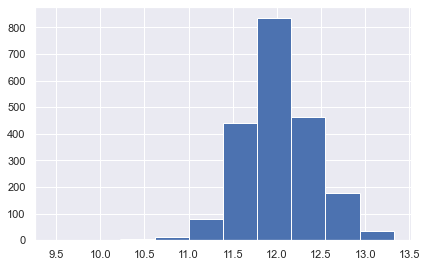

In [109]:
plt.hist(train['SalePrice'])

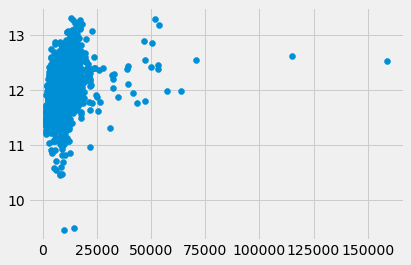

In [21]:
plt.scatter(train['Lot Area'], train['SalePrice'])

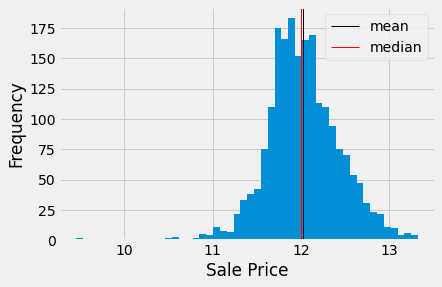

In [22]:
# price 
plt.hist(train['SalePrice'], bins=50)
plt.axvline(train['SalePrice'].mean(), color='k', linewidth=1, label = 'mean')
plt.axvline(train['SalePrice'].median(), color='r', linewidth=1, label = 'median')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.legend()

In [23]:
# kick out the log(price) <10 - outlier
train.drop(train.loc[train['SalePrice'] <10].index, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'log sale price')

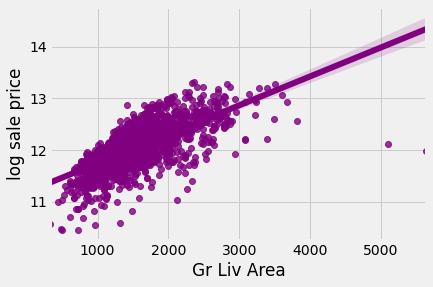

In [24]:
# check the socalled gr live area strong correlation - analysis later
sns.regplot(train['Gr Liv Area'], train['SalePrice'], color='purple')
plt.ylabel('log sale price')

In [25]:
# drop the gr live area > 4000
train.drop(train.loc[train['Gr Liv Area'] > 4000].index, inplace = True)

In [26]:
# create functions to inlcude all the feature, then plot with price in order to check the corr
# categorical features
# referenced code online 
def FP_plot(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/3))
    fig,ax=plt.subplots(nrows=nrows, ncols=3, figsize=(12, 5*nrows))
    ax=ax.ravel()
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # 
    for i, column in enumerate(list_of_columns):
        names = train.groupby(column).mean()['SalePrice'].sort_values().index
        sns.boxplot(x = dataframe[column], y = dataframe['SalePrice'], order = names, ax = ax[i])
        ax[i].set_title(f' SalePrice vs {column}', fontsize = 12)
        ax[i].set_ylabel('price', fontsize=12)
        ax[i].set_xlabel(column, fontsize=12)
        ax[i].set_xticklabels(names,rotation=90)
           

In [27]:
train.select_dtypes(include = 'object').columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Sale Type'],
      dtype='object')

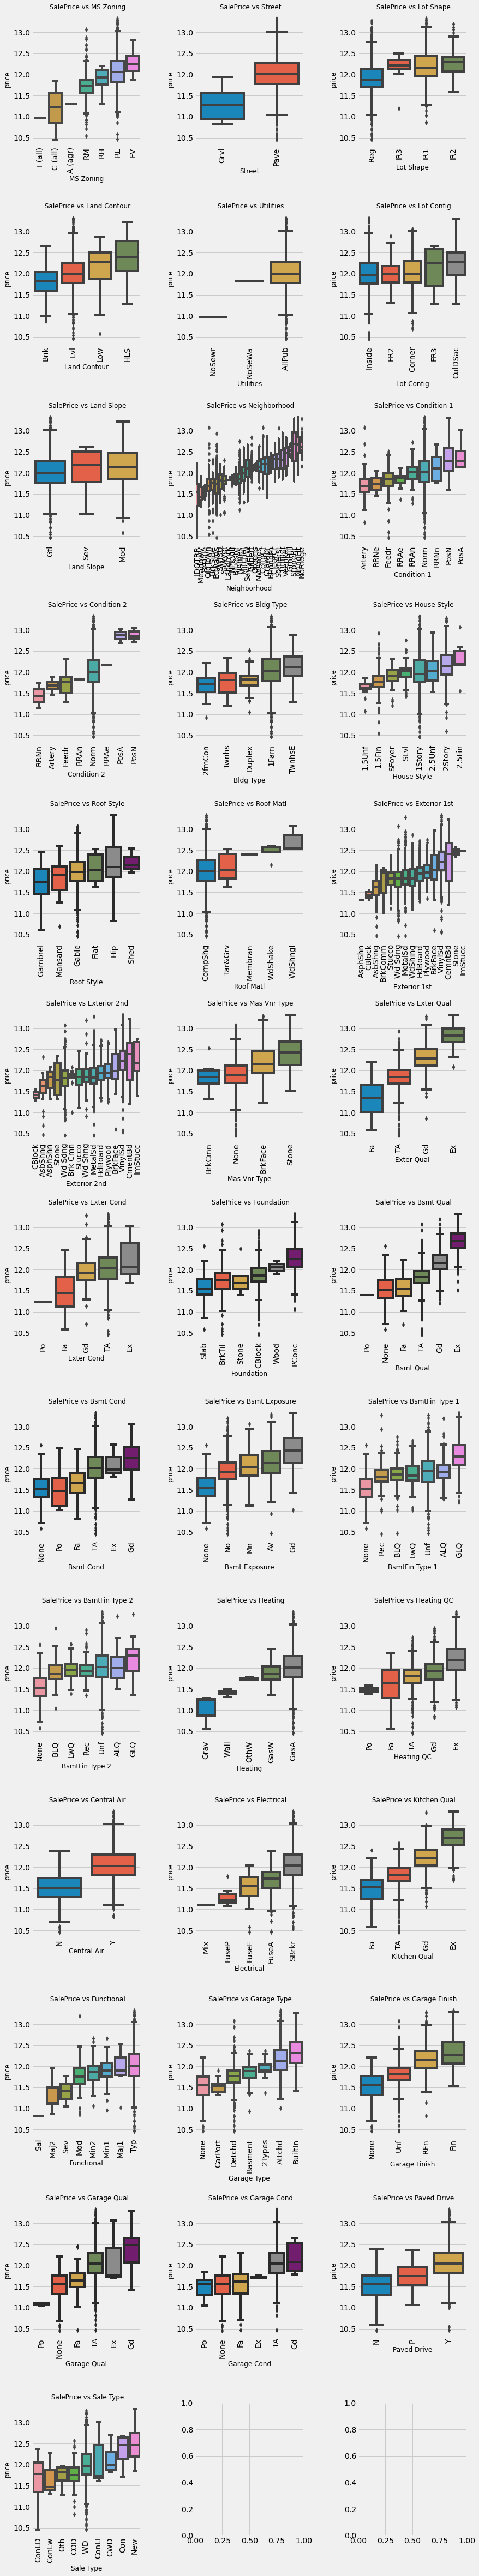

In [28]:
Categories_columns = train.select_dtypes(include = 'object').columns
FP_plot(train, Categories_columns)

In [29]:
# categorical columns
train.select_dtypes(include = 'object').columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Sale Type'],
      dtype='object')

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def anova(dataframe,list_of_columns):
    result =[]
    for i, col in enumerate(list_of_columns):
        mod = ols("dataframe['SalePrice'] ~ dataframe[col]",
                 data=dataframe).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)
        result.append(aov_table['PR(>F)'][0])
    return result

In [31]:
# anova analysis on variables for further selection
p = list(np.around(np.array(anova(train, Categories_columns)),4)) 
v = Categories_columns
a=list(zip(v,p))
list(filter(lambda x: x[1] >0.05, a))

[('Land Slope', 0.0715)]

In [32]:
# remove utilities and land slope columns p-value> 0.05
train.drop(['Utilities','Land Slope'], axis=1, inplace= True)

In [33]:
# drop features are redudant
# drop lot shape, lot config, land slope, roof style, heating
# combine condition 1 and 2 if possible, combine exterior 1 and 2, Bsmtfin type 1 and 2
# drop condition 2, exterior 2, Bsmtfin 2

train.drop(['Lot Shape', 'Lot Config', 'Roof Style', 'Heating', 
           'Condition 2','Exterior 2nd', 'BsmtFin Type 2'], axis=1, inplace= True)

In [34]:
train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Land Contour', 'Neighborhood', 'Condition 1', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Matl', 'Exterior 1st', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch',
     

In [35]:
# numeric features , check if any corr() values < 0.15
# can always adjust the corr() values to include features
abs(train.corr()['SalePrice']) < 0.15

Id                  True
PID                False
MS SubClass         True
Lot Frontage       False
Lot Area           False
Overall Qual       False
Overall Cond        True
Year Built         False
Year Remod/Add     False
Mas Vnr Area       False
BsmtFin SF 1       False
BsmtFin SF 2        True
Bsmt Unf SF        False
Total Bsmt SF      False
1st Flr SF         False
2nd Flr SF         False
Low Qual Fin SF     True
Gr Liv Area        False
Bsmt Full Bath     False
Bsmt Half Bath      True
Full Bath          False
Half Bath          False
Bedroom AbvGr      False
Kitchen AbvGr       True
TotRms AbvGrd      False
Fireplaces         False
Garage Yr Blt      False
Garage Cars        False
Garage Area        False
Wood Deck SF       False
Open Porch SF      False
Enclosed Porch     False
3Ssn Porch          True
Screen Porch        True
Pool Area           True
Misc Val            True
Mo Sold             True
Yr Sold             True
SalePrice          False
HouseAge           False


In [36]:
# drop numeric columns
# PID, ID - nothing to do with the model
# pool area - no pool
# drop | corr() score| less than 0.15  
# drop MS SubClass, overall cond, BsmtFin SF 2, Low Qual Fin SF, Bsmt Half Bath ,
# Bedroom AbvGr , Kitchen AbvGr , Enclosed Porch ,3Ssn Porch ,Screen Porch,Pool Area,
# Misc Val , mo sold, yr sod

In [37]:
# drop these numeric columns
train.drop(['PID', 'Id', 'Pool Area', 'MS SubClass','Overall Cond', 'BsmtFin SF 2', 
            'Low Qual Fin SF', 'Bsmt Half Bath' , 'Bedroom AbvGr', 'Kitchen AbvGr',
           'Enclosed Porch','3Ssn Porch','Screen Porch', 'Misc Val', 'Mo Sold', 'Yr Sold'], 
          axis=1, inplace = True)

In [38]:
train.columns

Index(['MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Land Contour',
       'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style',
       'Overall Qual', 'Year Built', 'Year Remod/Add', 'Roof Matl',
       'Exterior 1st', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Sale Type', 'SalePrice', 'HouseAge'],
      dtype='object')

In [39]:
# numerical features
train.select_dtypes(include = [np.number]).columns

Index(['Lot Frontage', 'Lot Area', 'Overall Qual', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Full Bath', 'Half Bath', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF', 'SalePrice', 'HouseAge'],
      dtype='object')

In [40]:
# we have to do features engineering on numerical that are not rational for modeling
# combine '''1st Flr SF', '2nd Flr SF' - as Flr SF
# Combine columns' 'bsmt full bath, full bath, halth bath' to object
train['Flr SF'] = train['1st Flr SF'] + train['2nd Flr SF']
train['Bath'] = train['Bsmt Full Bath'] + train['Full Bath'] + train['Half Bath']
# comibne 'wood deck sf, and open porch sf' - as Attach SF
train['Attach SF'] = train['Wood Deck SF'] + train['Open Porch SF']
# combine lot frontage and lot area
train['Lot SF'] = train['Lot Frontage'] + train['Lot Area']


In [41]:
train.columns

Index(['MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Land Contour',
       'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style',
       'Overall Qual', 'Year Built', 'Year Remod/Add', 'Roof Matl',
       'Exterior 1st', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'Sale Type', 'SalePrice', 'HouseAge',
       'Flr SF', 'Bath', 'Attach SF', 'Lot SF'],
      dtype='object')

In [42]:
# remove Year Built since we have HouseAge columns
# drop 'Bsmt unf sf' since there is total bsmt sf
# drop Garage Yr Blt
# And drop all the columns used for combination
train.drop(columns = ['Year Built', 'Bsmt Unf SF', 'Garage Yr Blt', '1st Flr SF',
                     '2nd Flr SF', 'Bsmt Full Bath', 'Full Bath', 'Half Bath',
                     'Wood Deck SF', 'Open Porch SF', 'Lot Frontage', 'Lot Area'], axis=1, inplace = True)

In [43]:
train.corr()['SalePrice']

Overall Qual      0.825880
Year Remod/Add    0.605027
Mas Vnr Area      0.453582
BsmtFin SF 1      0.431465
Total Bsmt SF     0.659142
Gr Liv Area       0.713879
TotRms AbvGrd     0.503741
Fireplaces        0.495708
Garage Cars       0.682241
Garage Area       0.672460
SalePrice         1.000000
HouseAge         -0.630354
Flr SF            0.723846
Bath              0.653303
Attach SF         0.442642
Lot SF            0.293901
Name: SalePrice, dtype: float64

In [44]:
train.shape

(2047, 44)

In [45]:
# dummy the categorical columns
train.select_dtypes(include = 'object').columns

Index(['MS Zoning', 'Street', 'Land Contour', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Matl', 'Exterior 1st', 'Mas Vnr Type',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type',
       'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Sale Type'],
      dtype='object')

In [46]:
train = pd.get_dummies(columns =['MS Zoning', 'Street', 'Land Contour', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Matl', 'Exterior 1st', 'Mas Vnr Type',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Functional', 'Garage Type',
       'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive',
       'Sale Type'], data=train, drop_first = True)

In [47]:
train.shape

(2047, 173)

# Do the same processing on test data

In [48]:
# import clean test data, already dummified
test = pd.read_csv('./datasets/clean_test.csv')

In [49]:
train.shape, test.shape
# now the training and testing features are different
# get rid of features are not in both set

((2047, 173), (878, 166))

In [50]:
y = train['SalePrice']
missingFeatures = list(set(train.columns.values) - set(test.columns.values))
train = train.drop(missingFeatures, axis=1)  # drop train features

In [51]:
missingFeatures = list(set(test.columns.values) - set(train.columns.values))
test = test.drop(missingFeatures, axis=1) # drop test features

In [52]:
train.shape, test.shape

((2047, 158), (878, 158))

Modeling

In [53]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import r2_score

In [54]:
# Train/test split your data.
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=42, test_size=.25)

In [55]:
# feature scalling
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# Linear Regression

In [56]:
from statsmodels.api import OLS, add_constant
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=42, test_size=.25)
sm_model = OLS(endog = y_train, exog = X_train)

In [57]:
sm_model = sm_model.fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.145e+05
Date:                Fri, 23 Jul 2021   Prob (F-statistic):                        0.00
Time:                        16:38:02   Log-Likelihood:                          1248.2
No. Observations:                1535   AIC:                                     -2192.
Df Residuals:                    1383   BIC:                                     -1381.
Df Model:                         152                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Overall Qual             0.0533      0.005     11.571      0.000       0.044       0.062
Year Remod/Add           0.0049   8.24e-05     59.045      0.000       0.005       0.005
Mas Vnr Area          1.986e-05   2.73e-05      0.727      0.467   -3.37e-05    7.34e-05
BsmtFin SF 1          6.066e-05   1.22e-05      4.959      0.000    3.67e-05    8.47e-05
Total Bsmt SF            0.0001   1.65e-05      6.843      0.000    8.07e-05       0.000
Gr Liv Area              0.0002   6.65e-05      2.435      0.015    3.15e-05       0.000
TotRms AbvGrd            0.0084      0.004      2.166      0.030       0.001       0.016
Fireplaces               0.0303      0.006      4.816      0.000       0.018       0.043
Garage Cars              0.0153      0.011      1.395      0.163      -0.006       0.037
Garage Area              0.0001   3.76e-05      2.798      0.005    3.15e-05       0.000
HouseAge                -0.0006      0.000     -1.954      0.051      -0.001    2.44e-06
Flr SF                7.996e-05   6.47e-05      1.235      0.217    -4.7e-05       0.000
Bath                     0.0127      0.006      2.193      0.028       0.001       0.024
Attach SF             4.878e-05   2.55e-05      1.916      0.056   -1.16e-06    9.87e-05
Lot SF                 2.68e-06   6.21e-07      4.315      0.000    1.46e-06     3.9e-06
MS Zoning_FV             0.3065      0.053      5.793      0.000       0.203       0.410
MS Zoning_I (all)        0.0946      0.136      0.696      0.487      -0.172       0.361
MS Zoning_RH             0.2949      0.062      4.782      0.000       0.174       0.416
MS Zoning_RL             0.2650      0.044      5.964      0.000       0.178       0.352
MS Zoning_RM             0.2288      0.043      5.364      0.000       0.145       0.312
Street_Pave              0.0895      0.055      1.615      0.107      -0.019       0.198
Land Contour_HLS        -0.0115      0.024     -0.479      0.632      -0.058       0.036
Land Contour_Low        -0.0131      0.029     -0.445      0.656      -0.071       0.045
Land Contour_Lvl        -0.0006      0.017     -0.033      0.974      -0.034       0.033
Neighborhood_Blueste     0.0253      0.059      0.427      0.669      -0.091       0.141
Neighborhood_BrDale     -0.0594      0.051     -1.174      0.240      -0.159       0.040
Neighborhood_BrkSide     0.0303      0.040      0.764      0.445      -0.047       0.108
Neighborhood_ClearCr     0.0204      0.040      0.504      0.614      -0.059       0.100
Neighborhood_CollgCr    -0.0137      0.031     -0.442      0.658      -0.075       0.047
Neighborhood_Crawfor     0.1179      0.036      3.247      0.001       0.047       0.189
Neighborhood_Edwards    -0.0500      0.034     

In [58]:
# linear regression model
lr = LinearRegression()

In [59]:
lr.fit(X_train, y_train)

LinearRegression()

In [60]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9399908466933058, 0.8989640682617299)

In [61]:
train_preds = lr.predict(X_test)
train_preds.shape

(512,)

In [62]:
# r2 score
lr_r2 = r2_score(y_test, train_preds)
print(lr_r2)

0.8989640682617299


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Linear Regression Model'}, xlabel='Predicted price', ylabel='SalePrice'>

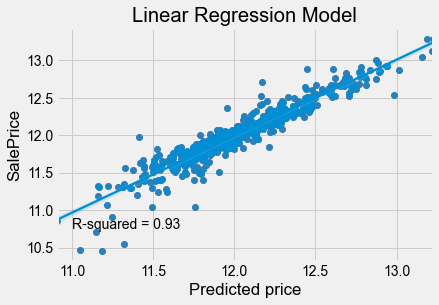

In [63]:

r_squared= 0.93
plt.scatter(train_preds, y_test, alpha=0.75, color='r')
plt.xlabel('Predicted price')
plt.ylabel('Actual price')
plt.title('Linear Regression Model')
plt.text(11, 10.75, 'R-squared = %0.2f' % r_squared)
sns.set_theme(color_codes=True)
sns.regplot(train_preds, y_test)

In [64]:
#Use Zip to See lr Coefficients beside our columns, replace with each instance
list(zip(train.columns,lr.coef_))

[('Overall Qual', 0.05280817370333401),
 ('Year Remod/Add', 0.0014384483356922684),
 ('Mas Vnr Area', 1.516403678431872e-05),
 ('BsmtFin SF 1', 5.573325824568111e-05),
 ('Total Bsmt SF', 9.965748400789817e-05),
 ('Gr Liv Area', 0.00016713085741895672),
 ('TotRms AbvGrd', 0.004288069596733855),
 ('Fireplaces', 0.023972245944557883),
 ('Garage Cars', 0.012889851272730532),
 ('Garage Area', 9.630942291639476e-05),
 ('HouseAge', -0.0009345837398489834),
 ('Flr SF', 8.211506385250034e-05),
 ('Bath', 0.01662104308370745),
 ('Attach SF', 6.636423442803185e-05),
 ('Lot SF', 2.5006182257686534e-06),
 ('MS Zoning_FV', 0.2440334756092283),
 ('MS Zoning_I (all)', 0.054111281487104305),
 ('MS Zoning_RH', 0.25023061221424386),
 ('MS Zoning_RL', 0.2103889182798935),
 ('MS Zoning_RM', 0.17087790275145573),
 ('Street_Pave', 0.05035327536070756),
 ('Land Contour_HLS', -0.013194382425169305),
 ('Land Contour_Low', -0.019446652173630924),
 ('Land Contour_Lvl', -0.004245407598897744),
 ('Neighborhood_Blues

# Ridge

In [65]:
# instantiate and fit model
ridge_model = Ridge(alpha =10)
ridge_model.fit(X_train, y_train)
# Evaluate model using R2.
print('Training Ridge Score',ridge_model.score(X_train, y_train))
print('Test Ridge Score',ridge_model.score(X_test, y_test))

Training Ridge Score 0.9346789503876216
Test Ridge Score 0.9023453814813689


In [66]:
# Cross-validate over our list of ridge alphas.
r_alphas = np.linspace(0, 10, 100)
ridge_cv = RidgeCV(alphas = r_alphas, scoring = 'r2', cv=5)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303...
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96969697,
        7.07070707,  7.17171717,  7.27272727,  7.37373737,  7.47474747,
        7.57575758,  7.67676768,  7.77777778,  7.87878788,  7.97979798,
        8.08080808,  8.18181818,  8.28282828,  8.38383838,  8.48484848,
        8.58585859,  8.68686869,  8.78787879,  8.88888889,  8.98989899,
        9.09090909,  9.19191919,  9.29292929,  9.39393939,  9.49494949,
        9.5959596 ,  9.6969697 ,  9.7979798 ,  9.8989899 , 10.        ]),
        cv=5, scoring='r2

In [67]:
ridge_cv.alpha_

4.94949494949495

In [68]:
print('Train RidgeCV Score:',ridge_cv.score(X_train, y_train))
print('Test RidgeCV Score:',ridge_cv.score(X_test, y_test))

Train RidgeCV Score: 0.9368300846468351
Test RidgeCV Score: 0.9019938835514084


# Lasso

In [69]:
# instantiate and fit model
lasso_model = Lasso(alpha =2)
lasso_model.fit(X_train, y_train)
# Evaluate model using R2.
print('Training Lasso Score',lasso_model.score(X_train, y_train))
print('Test Lasso Score',lasso_model.score(X_test, y_test))

Training Lasso Score 0.7934445587390928
Test Lasso Score 0.7515019237364304


In [70]:
l_alphas = np.linspace(0,2, 100)
lasso_cv = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
lasso_cv.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.727333330884335, tolerance: 0.019833575870800913
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.843866731860317

LassoCV(alphas=array([0.        , 0.02020202, 0.04040404, 0.06060606, 0.08080808,
       0.1010101 , 0.12121212, 0.14141414, 0.16161616, 0.18181818,
       0.2020202 , 0.22222222, 0.24242424, 0.26262626, 0.28282828,
       0.3030303 , 0.32323232, 0.34343434, 0.36363636, 0.38383838,
       0.4040404 , 0.42424242, 0.44444444, 0.46464646, 0.48484848,
       0.50505051, 0.52525253, 0.54545455, 0.56565657, 0.58585859,
       0.60606061...
       1.31313131, 1.33333333, 1.35353535, 1.37373737, 1.39393939,
       1.41414141, 1.43434343, 1.45454545, 1.47474747, 1.49494949,
       1.51515152, 1.53535354, 1.55555556, 1.57575758, 1.5959596 ,
       1.61616162, 1.63636364, 1.65656566, 1.67676768, 1.6969697 ,
       1.71717172, 1.73737374, 1.75757576, 1.77777778, 1.7979798 ,
       1.81818182, 1.83838384, 1.85858586, 1.87878788, 1.8989899 ,
       1.91919192, 1.93939394, 1.95959596, 1.97979798, 2.        ]),
        cv=5, max_iter=50000)

In [71]:
lasso_cv.alpha_

0.0

In [72]:
print('Train Lasso Score:',lasso_cv.score(X_train, y_train))
print('Test Lasso Score:',lasso_cv.score(X_test, y_test))

Train Lasso Score: 0.9399908466933058
Test Lasso Score: 0.898964068261716


# ElasticNet Regression

In [73]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [74]:
# instantiate and fit model
Enet_model = ElasticNet(alpha =2)
Enet_model.fit(X_train, y_train)
# Evaluate model using R2.
print('Training Enet Score',Enet_model.score(X_train, y_train))
print('Test Enet Score',Enet_model.score(X_test, y_test))

Training Enet Score 0.8311778323519915
Test Enet Score 0.8018190313927114


In [75]:
Enet_alphas = np.linspace(0.5, 1.0, 100)
Enet_ratio = 0.95
Enet_model = ElasticNetCV(alphas = Enet_alphas, l1_ratio = Enet_ratio, cv=5)
Enet_model = Enet_model.fit(X_train, y_train)

In [76]:
Enet_model.alpha_

0.5

In [77]:
# adjusted alphas and ratio, almost like lasso model
print(Enet_model.score(X_train, y_train))
print(Enet_model.score(X_test, y_test))

0.8451523632391718
0.8237486833999442


In [78]:
# Comparation 
print('R2 Score in Each Model\ntrain\ntest')
print()
print(" LR ".center(18, "="))
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))
print()
print(" Ridge ".center(18, "="))
print(ridge_model.score(X_train, y_train))
print(ridge_model.score(X_test, y_test))
print()
print(" Lasso ".center(18, "="))
print(lasso_model.score(X_train, y_train))
print(lasso_model.score(X_test, y_test))
print()
print(" ElasticNet ".center(18, "="))
print(Enet_model.score(X_train, y_train))
print(Enet_model.score(X_test, y_test))

R2 Score in Each Model
train
test

======= LR =======
0.9399908466933058
0.8989640682617299

===== Ridge ======
0.9346789503876216
0.9023453814813689

===== Lasso ======
0.7934445587390928
0.7515019237364304

=== ElasticNet ===
0.8451523632391718
0.8237486833999442


In [79]:
# Ridge model high score
# choose Ridge regression to do the prediction
# alphas already optimized  4.94949494949495
ridge_model = Ridge(alpha =4.95)
ridge_model.fit(X_test, y_test)

Ridge(alpha=4.95)

In [80]:
y_preds = ridge_model.predict(X_test)

Text(0.5, 1.0, 'Ridge Model Residual Distribution')

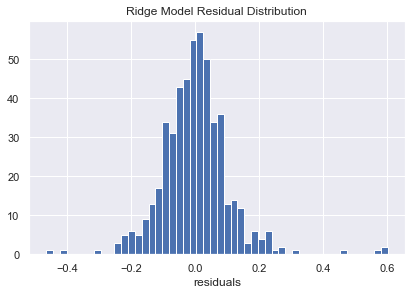

In [81]:
residuals = y_preds - y_test
from sklearn.metrics import mean_squared_error
plt.hist(residuals, bins=50)
plt.xlabel('residuals')
plt.title('Ridge Model Residual Distribution')

In [82]:
ridge_model.coef_

array([ 5.73581087e-02,  2.37622638e-03, -6.60937646e-06,  8.20730998e-05,
        7.51456856e-05,  1.14780633e-04, -2.21455994e-03,  1.87994494e-02,
        2.99632895e-02,  5.40555185e-05, -8.55881604e-04,  1.37762568e-04,
        1.95826296e-02,  3.20694209e-05,  4.52090557e-06,  2.76323223e-02,
        0.00000000e+00,  3.31345363e-02,  7.21418755e-02,  5.97719411e-02,
        0.00000000e+00,  8.59975076e-02,  2.47037167e-02, -6.14633466e-03,
        0.00000000e+00, -3.24564244e-02,  4.00984793e-02, -2.88848349e-02,
       -1.90485342e-02,  3.29187352e-02,  6.10121919e-04, -8.02363591e-03,
        0.00000000e+00, -6.99817836e-02, -9.72941231e-03,  5.35284385e-03,
        2.19028801e-02,  2.85074757e-03, -7.14165022e-03,  3.14843105e-02,
        1.80714791e-02, -6.06948926e-02,  2.47833245e-02, -2.22791267e-02,
       -4.41570960e-02,  3.49459634e-02,  4.27236218e-02, -2.88279246e-02,
        2.29041911e-02,  1.96617816e-02,  4.66116385e-02,  5.13230912e-02,
        4.17223914e-02, -

In [83]:
# use ridge regression model 
# transform log rmse back to rmse
from sklearn.metrics import mean_squared_error
print('RIDGE RMSE: ', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_preds))))

RIDGE RMSE:  18179.706506277693


In [84]:
print('number of features used: {}'.format(np.sum(ridge_model.coef_!=0)))

number of features used: 149


# create new submission

In [85]:
test_id = pd.read_csv('./datasets/test.csv')
submission = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': ridge_model.predict(test)}, index= None)
submission.reset_index(drop=True, inplace=True)

In [86]:
# change log price to price
submission['SalePrice'] = np.exp(submission['SalePrice'])

In [87]:
# sale price round to 2 decimals
submission['SalePrice'] = submission['SalePrice'].round(decimals=2)

In [88]:
submission.head()

,Id,SalePrice
0,2658,112080.04
1,2718,161345.67
2,2414,219525.62
3,1989,116903.07
4,625,172549.55


In [89]:
submission.shape

(878, 2)

In [90]:
submission.to_csv('./datasets/kaggle_final_submission.csv')

In [91]:
# suggestion to homeowner
Feature_df = pd.DataFrame(train.columns.values, columns = ['Features'])
Feature_df['Coef_'] = ridge_model.coef_
Feature_df['Abs(Coef_)'] = abs(ridge_model.coef_)
Feature_df = Feature_df.sort_values(by = ['Abs(Coef_)'], ascending = False)
FeaturesRecommendation = Feature_df.head(5)
FeaturesRecommendation.drop(columns = ['Abs(Coef_)'], axis=1)

,Features,Coef_
115,Heating QC_Fa,-0.095334
59,Bldg Type_Twnhs,-0.092976
21,Land Contour_HLS,0.085998
118,Central Air_Y,0.076728
18,MS Zoning_RL,0.072142
